<a href="https://colab.research.google.com/github/VijayRameshkumar/AI_Curriculum/blob/master/Deep_Learning/tree/gh-pages/MachineLearning/18_TF_custom_Callbacks/custom_callback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install --upgrade tensorflow==2.2.0

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import tensorflow.keras.callbacks as cbks
from tensorflow.keras.models import load_model
import os

# Configuration options
feature_vector_length = 2
num_classes = 1
%load_ext tensorboard

## 1. Feature Engineering

In [3]:
data = pd.read_csv("data.csv")

data['label'] = data['label'].astype('int32')

data['2f1'] = data['f1'] * 2
data['f1^2'] = data['f1'] ** 2
data['sqrt_f1'] = np.sqrt(data['f1'])
data['log_f1'] = np.log(data['f1'])
data['exp_f1'] = np.exp(data['f1'])
data['sin_f1'] = np.sin(data['f1'])
data['tan_f1'] = np.tan(data['f1'])

data['2f2'] = data['f2'] * 2
data['f2^2'] = data['f2'] ** 2
data['sqrt_f2'] = np.sqrt(data['f2'])
data['log_f2'] = np.log(data['f2'])
data['exp_f2'] = np.exp(data['f2'])
data['sin_f2'] = np.sin(data['f2'])
data['tan_f2'] = np.tan(data['f2'])

data['f1f2'] = data['f1'] * data['f2']
data['2_f1f1'] = data['2f1'] * data['2f2']
data['sqrt_f1f2'] = data['sqrt_f1'] * data['sqrt_f2']
data['2_log_f1f2'] = data['log_f1'] * data['log_f2']
data['2_f1^2'] = data['f1^2'] * data['f2^2']
data['tan_f1f2'] = data['tan_f1'] * data['tan_f2']
data['sin_f1f2'] = data['sin_f1'] * data['sin_f2']
data['exp_f1f2'] = data['exp_f1'] * data['exp_f2']

data.fillna(0, inplace=True)

data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,f1,f2,label,2f1,f1^2,sqrt_f1,log_f1,exp_f1,sin_f1,tan_f1,2f2,f2^2,sqrt_f2,log_f2,exp_f2,sin_f2,tan_f2,f1f2,2_f1f1,sqrt_f1f2,2_log_f1f2,2_f1^2,tan_f1f2,sin_f1f2,exp_f1f2
0,0.450564,1.074305,0,0.901127,0.203008,0.671240,-0.797256,1.569196,0.435473,0.483750,2.148610,1.154131,1.036487,0.071674,2.927957,0.879259,1.845851,0.484043,1.936171,0.695732,-0.057142,0.234297,0.892931,0.382894,4.594539
1,0.085632,0.967682,0,0.171263,0.007333,0.292629,-2.457701,1.089405,0.085527,0.085841,1.935363,0.936408,0.983708,-0.032852,2.631836,0.823573,1.451971,0.082864,0.331456,0.287861,0.080740,0.006866,0.124639,0.070438,2.867135
2,0.117326,0.971521,1,0.234652,0.013765,0.342529,-2.142800,1.124486,0.117057,0.117867,1.943041,0.943852,0.985657,-0.028893,2.641959,0.825744,1.463970,0.113984,0.455938,0.337616,0.061911,0.012992,0.172554,0.096659,2.970845
3,0.982179,-0.380408,0,1.964358,0.964676,0.991050,-0.017982,2.670269,0.831709,1.498005,-0.760817,0.144711,0.000000,0.000000,0.683582,-0.371300,-0.399886,-0.373629,-1.494517,0.000000,0.000000,0.139599,-0.599032,-0.308813,1.825348
4,-0.720352,0.955850,0,-1.440705,0.518908,0.000000,0.000000,0.486581,-0.659650,-0.877692,1.911699,0.913648,0.977676,-0.045155,2.600879,0.816804,1.415813,-0.688548,-2.754194,0.000000,0.000000,0.474099,-1.242647,-0.538804,1.265538


## 2. Data Splitting

In [4]:
target = data['label']

data = data.drop(['label'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.20, random_state=3, shuffle=True, stratify=target)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(16000, 24) (4000, 24) (16000,) (4000,)


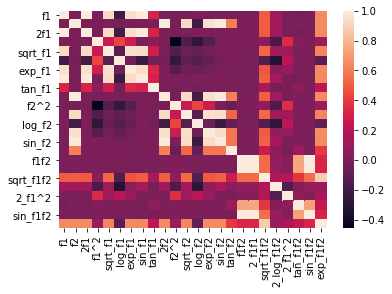

In [5]:
import seaborn as sns

sns.heatmap(data.corr());

## 3. Callbacks

In [6]:
from keras import backend as K

def micro_f1(y_true, y_pred):
  def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
  precision = precision(y_true, y_pred)
  recall = recall(y_true, y_pred)
  #2*pi*row / (pi + row): micro-f1
  micro_f1 = (2*precision*recall)/(precision+recall+K.epsilon()) 
  return micro_f1

def AUC_custom(y, pred):
  '''
  Calculates AUC for various Thresholds
  '''
  m = tf.keras.metrics.AUC(num_thresholds=3)
  m.update_state(y, pred)
  auc = m.result().numpy()
  m.reset_states()
  return auc

def get_model(act_fn, initializer, metrics=None):
  # Set the input shape
  input_shape = (X_train.shape[1],)
  print(f'Feature shape: {input_shape}')
  # Create the model
  model = Sequential()
  model.add(Dense(50, input_shape=input_shape, activation=act_fn, kernel_initializer=initializer))
  model.add(Dense(25, activation=act_fn))
  model.add(Dense(10, activation=act_fn))
  model.add(Dense(5, activation=act_fn))
  model.add(Dense(3, activation=act_fn))
  model.add(Dense(num_classes, activation='sigmoid'))
  sgd = SGD(lr=0.01, momentum=0.9)
  # Configure the model and start training
  if metrics == None:
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=[micro_f1, AUC_custom], run_eagerly=True)
  elif metrics == 'AUC_custom':
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=[AUC_custom], run_eagerly=True)
  elif metrics == 'micro_f1':
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=[micro_f1], run_eagerly=True)
  else:
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=[metrics], run_eagerly=True)
  return model

In [7]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.val_acc = dict()
        self.lr = dict() 
        self.val_loss = dict()

    def on_train_begin(self, logs=None):
        keys = list(logs.keys())

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        title="Learning Rate Schedule"
        epochs = list(self.lr.keys())
        lrs = list(self.lr.values())

        # the learning rate schedule
        plt.style.use("ggplot")
        plt.figure()
        plt.plot(epochs, lrs, color='green', marker='o', linestyle='dashed')
        plt.title(title)
        plt.xlabel("Epoch #")
        plt.ylabel("Learning Rate")
        plt.savefig("lrng_rate.png")
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("\nEnd epoch {} of training; got log keys: {}".format(epoch, logs))

        try : 
          if logs['val_micro_f1']:
            self.val_acc[str(epoch)] = logs['val_micro_f1']
            val_loss = logs['val_loss']
            self.val_loss[epoch] = val_loss
          elif logs['AUC_custom']:
            self.val_acc[str(epoch)] = logs['val_AUC_custom']
            val_loss = logs['val_loss']
            self.val_loss[epoch] = val_loss

        except:
          pass

        if epoch>1:
          #learning rate reduce if prev_val_acc > next_val_acc epoch drop 10%
          if self.val_acc[str(epoch-1)] > self.val_acc[str(epoch)]:
            lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
            scheduled_lr = lr * 0.1
            tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)

            print(f"\n custom learning rate by val_accracy if prev_val_acc > next_val_acc epoch drop 10% : {lr}\n")
            self.lr[str(epoch+1)]= lr
          
          #save model if prev_val_acc < next_val_acc BEST_MODEL = TRUE
          elif self.val_acc[str(epoch-1)] < self.val_acc[str(epoch)]:
            try:
              os.makedirs(("/content/best_model"))
            except:
              pass

            name = '/content/best_model/weights%08d.h5' % epoch

            # Record the best weights if current results is better.
            model = self.model.get_weights()
            print("\n", "#"*100, "\n", "Best Weights Saved : ", "\n", "#"*100)
            # model = load_model(model)
            self.model.save(name)

            # self.model.savefig("/content/best_model/best_model.png")
            with open("/content/best_model/best_weights.txt", "w+") as f:
              f.write(str(model))

        #learning rate for every 3 epoch drop 5%
          elif ((epoch+1) % 3) == 0:
            lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
            schedule = float(lr * 0.05)
            tf.keras.backend.set_value(self.model.optimizer.lr, schedule)
            print(f"\n custom learning rate by every 3rd epoch {lr}\n")
            self.lr[str(epoch+1)]= lr

        # early stopping if val_acc is not improved for last 2 epochs
        elif epoch >= 2:
          val_loss = type(logs['val_loss'])
          if round(self.val_acc[str(epoch-1)] - self.val_acc[str(epoch-2)], 4) == 0:
            print("\n", "#"*100, "\n", "Early Stopping Executed: ", "\n", "#"*100)
            self.model.stop_training = True

        
          #if val loss is nan, stop_training
          elif val_loss != 'int' or val_loss != 'float':
            print("\n", "#"*100, "\n", "val loss is nan - Train Termination Execcuted: ", "\n", "#"*100)
            self.model.stop_training = True

    def on_test_begin(self, logs=None):
        keys = list(logs.keys())

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("\nStop testing; got log keys: {}".format(logs))

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())

    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())

    def on_test_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())

    def on_test_batch_end(self, batch, logs=None):
        keys = list(logs.keys())

    def on_predict_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())

    def on_predict_batch_end(self, batch, logs=None):
        keys = list(logs.keys())

## 4. Model

### Model 1

In [8]:
import datetime
import os

log_dir=os.path.join("logs1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True, write_grads=True)

In [ ]:
%tensorboard --logdir logs1

Feature shape: (24,)
Epoch 1/20
51/52 [============================>.] - ETA: 0s - loss: 0.6686 - micro_f1: 0.5306 - AUC_custom: 0.5741
Stop testing; got log keys: {'loss': 0.6109927296638489, 'micro_f1': 0.6912460923194885, 'AUC_custom': 0.6652476787567139}
52/52 [==============================] - 3s 43ms/step - loss: 0.6679 - micro_f1: 0.5329 - AUC_custom: 0.5756 - val_loss: 0.6110 - val_micro_f1: 0.6912 - val_AUC_custom: 0.6652

End epoch 0 of training; got log keys: {'loss': 0.6494277119636536, 'micro_f1': 0.594025731086731, 'AUC_custom': 0.6146937012672424, 'val_loss': 0.6109927296638489, 'val_micro_f1': 0.6912460923194885, 'val_AUC_custom': 0.6652476787567139}
Epoch 2/20
51/52 [============================>.] - ETA: 0s - loss: 0.6130 - micro_f1: 0.6665 - AUC_custom: 0.6601
Stop testing; got log keys: {'loss': 0.6081868410110474, 'micro_f1': 0.6309722065925598, 'AUC_custom': 0.6671809554100037}
52/52 [==============================] - 2s 35ms/step - loss: 0.6129 - micro_f1: 0.6663

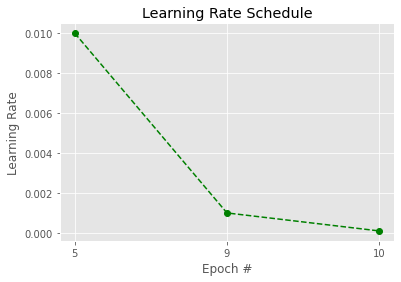

In [10]:
model1 = get_model('tanh', 'RandomUniform')

history_tanh = model1.fit(X_train, Y_train.ravel(), epochs=20, batch_size=250, 
                          verbose=1, validation_split=0.2,
                          callbacks=[CustomCallback(), tensorboard_callback])

# Test the model after training
test_results = model1.evaluate(X_test, Y_test, verbose=1)

print(f'\nTest results - Loss: {test_results[0]} - micro_f1: {test_results[1]}% - AUC_custom: {test_results[2]}%')

In [11]:
from sklearn.metrics import classification_report, accuracy_score

ypred = model1.predict(X_test)

ypred = [1 if i>=0.5 else 0 for i in ypred.ravel()]

print("accuracy_score is ", accuracy_score(Y_test, ypred), "\n")

print("AUC_score is ", test_results[1], "\n")

print(classification_report(Y_test, ypred))

accuracy_score is  0.67475 

AUC_score is  0.660398542881012 

              precision    recall  f1-score   support

           0       0.67      0.70      0.68      2000
           1       0.68      0.65      0.67      2000

    accuracy                           0.67      4000
   macro avg       0.68      0.67      0.67      4000
weighted avg       0.68      0.67      0.67      4000



### Model 2

In [ ]:
import datetime
import os

log_dir=os.path.join("logs2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback_2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True, write_grads=True)

%tensorboard --logdir logs2

Feature shape: (24,)
Epoch 1/20
52/52 [==============================] - ETA: 0s - loss: 0.6925 - micro_f1: 0.3975 - AUC_custom: 0.5246
Stop testing; got log keys: {'loss': 0.6892591714859009, 'micro_f1': 0.2571571469306946, 'AUC_custom': 0.5269703269004822}
52/52 [==============================] - 2s 41ms/step - loss: 0.6925 - micro_f1: 0.3985 - AUC_custom: 0.5248 - val_loss: 0.6893 - val_micro_f1: 0.2572 - val_AUC_custom: 0.5270

End epoch 0 of training; got log keys: {'loss': 0.6917986869812012, 'micro_f1': 0.4513503611087799, 'AUC_custom': 0.5345473289489746, 'val_loss': 0.6892591714859009, 'val_micro_f1': 0.2571571469306946, 'val_AUC_custom': 0.5269703269004822}
Epoch 2/20
51/52 [============================>.] - ETA: 0s - loss: 0.6882 - micro_f1: 0.4400 - AUC_custom: 0.5541
Stop testing; got log keys: {'loss': 0.6804736852645874, 'micro_f1': 0.5373701453208923, 'AUC_custom': 0.6073186993598938}
52/52 [==============================] - 2s 37ms/step - loss: 0.6882 - micro_f1: 0.442

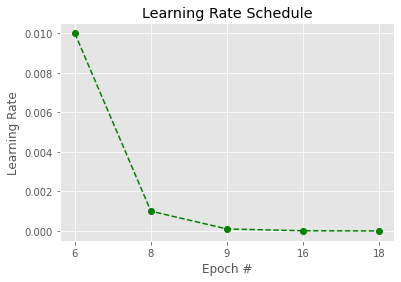

In [13]:
model2 = get_model('relu', 'RandomUniform')

history_relu_1 = model2.fit(X_train, Y_train.ravel(), epochs=20, batch_size=250, 
                         verbose=1, validation_split=0.2, 
                         callbacks=[CustomCallback(), tensorboard_callback_2])

# Test the model after training
test_results = model2.evaluate(X_test, Y_test, verbose=1)

print(f'\nTest results - Loss: {test_results[0]} - micro_f1: {test_results[1]}%')

In [14]:
from sklearn.metrics import classification_report, accuracy_score

ypred = model2.predict(X_test)

ypred = [1 if i>=0.5 else 0 for i in ypred.ravel()]

print("accuracy_score is ", accuracy_score(Y_test, ypred), "\n")

print("AUC_score is ", test_results[1], "\n")

print(classification_report(Y_test, ypred))

accuracy_score is  0.67425 

AUC_score is  0.6675434112548828 

              precision    recall  f1-score   support

           0       0.67      0.68      0.68      2000
           1       0.68      0.67      0.67      2000

    accuracy                           0.67      4000
   macro avg       0.67      0.67      0.67      4000
weighted avg       0.67      0.67      0.67      4000



### Model 3

In [ ]:
import datetime
import os

log_dir=os.path.join("logs3", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback_3 = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True, write_grads=True)

%tensorboard --logdir logs3

Feature shape: (24,)
Epoch 1/20
51/52 [============================>.] - ETA: 0s - loss: 0.6838 - micro_f1: 0.5068 - AUC_custom: 0.5531
Stop testing; got log keys: {'loss': 0.6649491190910339, 'micro_f1': 0.5792978405952454, 'AUC_custom': 0.6070863008499146}
52/52 [==============================] - 2s 37ms/step - loss: 0.6836 - micro_f1: 0.5083 - AUC_custom: 0.5543 - val_loss: 0.6649 - val_micro_f1: 0.5793 - val_AUC_custom: 0.6071

End epoch 0 of training; got log keys: {'loss': 0.6790311336517334, 'micro_f1': 0.5454391837120056, 'AUC_custom': 0.5846741795539856, 'val_loss': 0.6649491190910339, 'val_micro_f1': 0.5792978405952454, 'val_AUC_custom': 0.6070863008499146}
Epoch 2/20
51/52 [============================>.] - ETA: 0s - loss: 0.6583 - micro_f1: 0.5953 - AUC_custom: 0.6243
Stop testing; got log keys: {'loss': 0.6397657990455627, 'micro_f1': 0.636598527431488, 'AUC_custom': 0.6442986726760864}
52/52 [==============================] - 2s 36ms/step - loss: 0.6581 - micro_f1: 0.5961

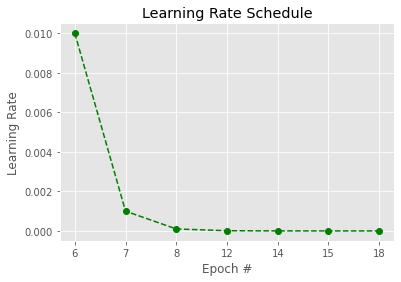

In [16]:
model3 = get_model('relu', 'he_uniform')

history_relu_2 = model3.fit(X_train, Y_train.ravel(), epochs=20, batch_size=250, 
                         verbose=1, validation_split=0.2, 
                         callbacks=[CustomCallback(), tensorboard_callback_3])

# Test the model after training
test_results = model3.evaluate(X_test, Y_test, verbose=1)

print(f'\nTest results - Loss: {test_results[0]} - micro_f1: {test_results[1]}% - custom_AUC: {test_results[2]}%')

In [17]:
from sklearn.metrics import classification_report, accuracy_score

ypred = model3.predict(X_test)

ypred = [1 if i>=0.5 else 0 for i in ypred.ravel()]

print("accuracy_score is ", accuracy_score(Y_test, ypred), "\n")

print("AUC_score is ", test_results[1], "\n")

print(classification_report(Y_test, ypred))

accuracy_score is  0.67425 

AUC_score is  0.6620919704437256 

              precision    recall  f1-score   support

           0       0.67      0.69      0.68      2000
           1       0.68      0.65      0.67      2000

    accuracy                           0.67      4000
   macro avg       0.67      0.67      0.67      4000
weighted avg       0.67      0.67      0.67      4000



### Model 4

In [ ]:
import datetime
import os

log_dir=os.path.join("logs4", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback_4 = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True, write_grads=True)

%tensorboard --logdir logs4

In [19]:
model4 = get_model('relu', 'he_uniform', 'AUC')

history_relu_3 = model4.fit(X_train, Y_train, epochs=20, batch_size=250, 
                         verbose=1, validation_split=0.2, 
                         callbacks=[tensorboard_callback_4])

# Test the model after training
test_results = model4.evaluate(X_test, Y_test, verbose=1)

print(f'\nTest results - Loss: {test_results[0]} - AUC: {test_results[1]}%')

Feature shape: (24,)
Epoch 1/20
52/52 [==============================] - 1s 25ms/step - loss: 0.7767 - auc_4275: 0.5497 - val_loss: 0.6628 - val_auc_4275: 0.6388
Epoch 2/20
52/52 [==============================] - 1s 22ms/step - loss: 0.6612 - auc_4275: 0.6453 - val_loss: 0.6399 - val_auc_4275: 0.7138
Epoch 3/20
52/52 [==============================] - 1s 22ms/step - loss: 0.6368 - auc_4275: 0.7200 - val_loss: 0.6217 - val_auc_4275: 0.7290
Epoch 4/20
52/52 [==============================] - 1s 22ms/step - loss: 0.6215 - auc_4275: 0.7285 - val_loss: 0.6138 - val_auc_4275: 0.7326
Epoch 5/20
52/52 [==============================] - 1s 21ms/step - loss: 0.6151 - auc_4275: 0.7318 - val_loss: 0.6117 - val_auc_4275: 0.7352
Epoch 6/20
52/52 [==============================] - 1s 21ms/step - loss: 0.6171 - auc_4275: 0.7269 - val_loss: 0.6084 - val_auc_4275: 0.7361
Epoch 7/20
52/52 [==============================] - 1s 21ms/step - loss: 0.6127 - auc_4275: 0.7266 - val_loss: 0.6061 - val_auc_4275:

In [20]:
from sklearn.metrics import classification_report, accuracy_score

ypred = model4.predict(X_test)

ypred = [1 if i>=0.5 else 0 for i in ypred.ravel()]

print("accuracy_score is ", accuracy_score(Y_test, ypred), "\n")

print("AUC_score is ", test_results[1], "\n")

print(classification_report(Y_test, ypred))

accuracy_score is  0.67025 

AUC_score is  0.740996241569519 

              precision    recall  f1-score   support

           0       0.71      0.58      0.64      2000
           1       0.64      0.76      0.70      2000

    accuracy                           0.67      4000
   macro avg       0.68      0.67      0.67      4000
weighted avg       0.68      0.67      0.67      4000



In [ ]:
!pip install shap

In [22]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

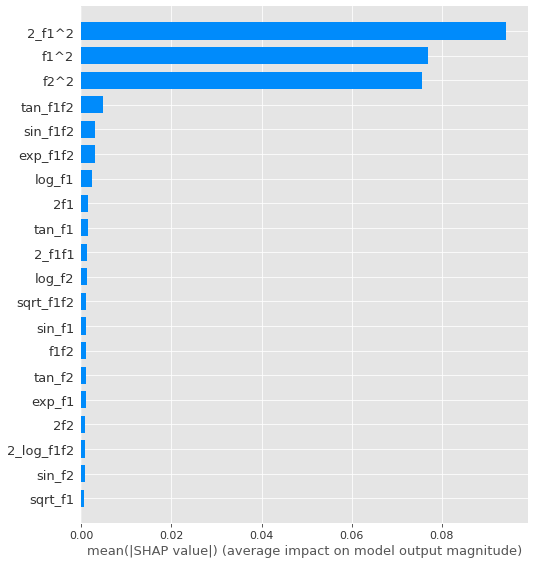

In [25]:
import shap

shap_values = shap.TreeExplainer(model).shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")

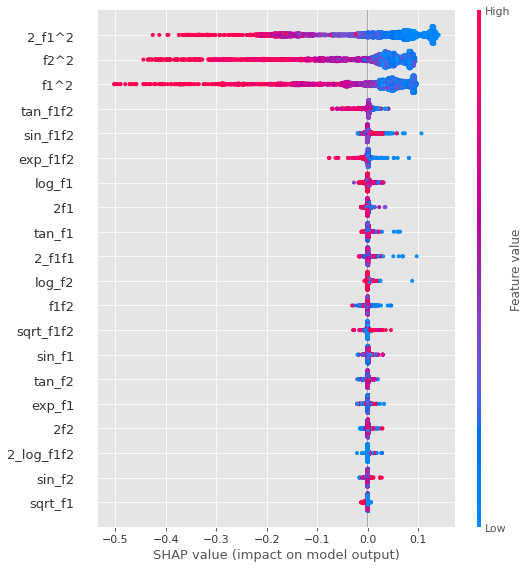

In [26]:
import matplotlib.pyplot as plt

shap_values = shap.TreeExplainer(model).shap_values(X_test)

f = plt.figure()
shap.summary_plot(shap_values, X_test)
f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)

#Result

In [27]:
from prettytable import PrettyTable 

# Specify the Column Names while initializing the Table 
myTable = PrettyTable(["Model", "micro-F1", "AUC", 'Accuracy', 'Activation', 'Weight_Initializer']) 

# Add rows 
myTable.add_row(["1", "66 %", "67 %", "67 %", 'tanh', 'RandomUniform']) 
myTable.add_row(["2", "66 %", "67 %", "67 %", 'relu', 'RandomUniform']) 
myTable.add_row(["3", "66", "67", "67 %", 'relu', 'he_uniform']) 
myTable.add_row(["4", "67", "74", "67 %", 'relu', 'he_uniform']) 

print(myTable)

+-------+----------+------+----------+------------+--------------------+
| Model | micro-F1 | AUC  | Accuracy | Activation | Weight_Initializer |
+-------+----------+------+----------+------------+--------------------+
|   1   |   66 %   | 67 % |   67 %   |    tanh    |   RandomUniform    |
|   2   |   66 %   | 67 % |   67 %   |    relu    |   RandomUniform    |
|   3   |    66    |  67  |   67 %   |    relu    |     he_uniform     |
|   4   |    67    |  74  |   67 %   |    relu    |     he_uniform     |
+-------+----------+------+----------+------------+--------------------+
